In [ ]:
import sys
!{sys.executable} -m pip install osmnx geopandas shapely rasterio geemap tqdm pillow pyproj geedim requests rtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.7 MB/s eta 0:00:00


















NEW


In [ ]:
# =========================================================
# Germany Solar Dataset Collection Script
# (Stable, per-state Overpass API queries with refined utility subtypes)
# =========================================================
#!pip install -q geopandas shapely osmnx tqdm requests pandas numpy rtree pyproj

import time, random, requests
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
from shapely.ops import unary_union
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------------- Settings ----------------
OVERPASS_URLS = [
    "https://overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter",
    "https://overpass.openstreetmap.ru/api/interpreter",
]
TIMEOUT = 1800                     # Timeout in seconds for Overpass API queries
SLEEP_BETWEEN = 3                   # Seconds to wait between Overpass API requests (avoid rate limits)
NEG_EXCLUSION_M = 120               # Minimum distance (in meters) from solar points for negative samples
RANDOM_SEED = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

# Strict rooftop filter: only keep nodes explicitly tagged as rooftop-mounted solar
ROOF_STRICT = '["generator:source"="solar"]["location"="roof"]'

# List of German states (Bundesländer) to iterate over for bounding box queries
BUNDESLAENDER = [
    "Baden-Württemberg, Germany","Bavaria, Germany","Berlin, Germany","Brandenburg, Germany",
    "Bremen, Germany","Hamburg, Germany","Hesse, Germany","Mecklenburg-Vorpommern, Germany",
    "Lower Saxony, Germany","North Rhine-Westphalia, Germany","Rhineland-Palatinate, Germany",
    "Saarland, Germany","Saxony, Germany","Saxony-Anhalt, Germany",
    "Schleswig-Holstein, Germany","Thuringia, Germany",
]

# ---------------- Helper Functions ----------------
def overpass(query, url_idx=0, max_retries=6, backoff=6):
    """
    Send a query to the Overpass API with retry logic and automatic URL rotation.

    Parameters:
        query (str)       : Overpass QL query string
        url_idx (int)     : Starting index for the Overpass URL list
        max_retries (int) : Maximum number of retry attempts
        backoff (int)     : Backoff multiplier in seconds between retries

    Returns:
        (data, url_idx) : JSON data from Overpass and updated URL index
    """
    last_err = None
    for attempt in range(max_retries):
        url = OVERPASS_URLS[url_idx % len(OVERPASS_URLS)]
        try:
            r = requests.post(url, data={"data": query}, timeout=TIMEOUT)
            if r.status_code in (429, 504, 502, 503):  # Handle rate limit / temporary errors
                time.sleep(backoff*(attempt+1)); url_idx += 1; continue
            r.raise_for_status()
            data = r.json()
            if not data.get("elements"):
                time.sleep(backoff*(attempt+1)); url_idx += 1; continue
            return data, url_idx
        except Exception as e:
            last_err = e
            time.sleep(backoff*(attempt+1)); url_idx += 1
    # If all retries fail, return an empty element list (continue workflow without stopping)
    return {"elements": []}, url_idx

def extract_centers_with_tags(elements):
    """
    Extract latitude, longitude, and tags from Overpass JSON elements.
    Works for nodes, ways, and relations.
    """
    out = []
    for e in elements:
        if "lat" in e and "lon" in e:
            lat, lon = e["lat"], e["lon"]
        elif "center" in e:  # Ways/relations have a 'center'
            lat, lon = e["center"]["lat"], e["center"]["lon"]
        else:
            continue
        out.append(((float(lat), float(lon)), e.get("tags", {})))
    return out

def unique_latlon_with_tags(items, decimals=6):
    """
    Remove duplicates based on rounded lat/lon coordinates.

    Parameters:
        items    : List of ((lat, lon), tags) tuples
        decimals : Number of decimal places to round to (to merge very close points)
    """
    seen, res = set(), []
    for (lat, lon), tags in items:
        key = (round(lat, decimals), round(lon, decimals))
        if key not in seen:
            seen.add(key); res.append(((lat, lon), tags))
    return res

def tags_ci(tags, key):
    """Case-insensitive tag value lookup."""
    for k, v in tags.items():
        if k.lower() == key.lower():
            return str(v)
    return ""

def any_tag_value_in(tags, keys, values_ci):
    """
    Check if any given tag key has a value matching one of the provided values (case-insensitive).
    """
    for k in keys:
        v = tags_ci(tags, k).lower()
        if v and any(v == val for val in values_ci):
            return True
    return False

def contains_keyword(text, keywords_ci):
    """Check if a lowercase text contains any of the given lowercase keywords."""
    t = (text or "").lower()
    return any(kw in t for kw in keywords_ci)

# ---- Refined subtype classification rules for utility-scale solar ----
THERMAL_KEYS      = ["generator:method","plant:method","generator:source","solar:thermal","solar_thermal:type"]
THERMAL_VALUES_CI = ["thermal","solar_thermal"]

FARM_KEYS         = ["generator:type","plant:type","site:type","power:plant:type"]
FARM_VALUES_CI    = ["solar_farm","farm"]
FARM_NAME_KWS     = ["solar farm","solarfarm","solarfeld","freiflächen","freiland"]

PARK_KEYS         = ["generator:type","plant:type","site:type","power:plant:type"]
PARK_VALUES_CI    = ["solar_park","park"]
PARK_NAME_KWS     = ["solar park","solarpark"]

def classify_subtype(tags):
    """
    Classify utility-scale solar installations into subtypes:
    - thermal : Solar thermal power plants
    - farm    : Solar farms (large ground-mounted installations)
    - park    : Solar parks (often similar to farms, different tagging)
    - unknown : Any other utility-scale installation
    """
    if any_tag_value_in(tags, THERMAL_KEYS, THERMAL_VALUES_CI) or tags_ci(tags, "solar:thermal"):
        return "thermal"
    if any_tag_value_in(tags, FARM_KEYS, FARM_VALUES_CI) or contains_keyword(tags_ci(tags,"name"), FARM_NAME_KWS):
        return "farm"
    if any_tag_value_in(tags, PARK_KEYS, PARK_VALUES_CI) or contains_keyword(tags_ci(tags,"name"), PARK_NAME_KWS):
        return "park"
    return "unknown"

# ---------------- AOI & per-state bounding boxes ----------------
print("== Getting Germany AOI ==")
de = ox.geocode_to_gdf("Germany").to_crs("EPSG:4326")
de_poly = de.geometry.iloc[0]
utm = de.estimate_utm_crs()

print("== Computing bounding boxes for each state ==")
state_boxes = {}
for name in BUNDESLAENDER:
    g = ox.geocode_to_gdf(name).to_crs("EPSG:4326").geometry.iloc[0]
    minx, miny, maxx, maxy = g.bounds
    state_boxes[name] = (float(minx), float(miny), float(maxx), float(maxy))

# ---------------- Collect utility-scale solar ----------------
util_items = []
url_idx = 0
print("== Collecting utility-scale solar (per-state bbox; keep all) ==")
for state in tqdm(BUNDESLAENDER):
    minx, miny, maxx, maxy = state_boxes[state]
    q = f"""
    [out:json][timeout:{TIMEOUT}];
    (
      node["power"="plant"]["plant:source"="solar"]({miny},{minx},{maxy},{maxx});
      way ["power"="plant"]["plant:source"="solar"]({miny},{minx},{maxy},{maxx});
      rel ["power"="plant"]["plant:source"="solar"]({miny},{minx},{maxy},{maxx});

      node["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
      way ["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
      rel ["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
    );
    out center tags;
    """
    data, url_idx = overpass(q, url_idx)
    util_items.extend(extract_centers_with_tags(data.get("elements", [])))
    time.sleep(SLEEP_BETWEEN)

util_items = unique_latlon_with_tags(util_items)
print(f"Utility-scale count: {len(util_items)}")

# ---------------- Collect rooftop solar (strict) ----------------
roof_items = []
print("== Collecting rooftop solar (strict location=roof; keep all) ==")
for state in tqdm(BUNDESLAENDER):
    minx, miny, maxx, maxy = state_boxes[state]
    q = f"""
    [out:json][timeout:{TIMEOUT}];
    (
      node{ROOF_STRICT}({miny},{minx},{maxy},{maxx});
      way {ROOF_STRICT}({miny},{minx},{maxy},{maxx});
      rel {ROOF_STRICT}({miny},{minx},{maxy},{maxx});
    );
    out center;
    """
    data, url_idx = overpass(q, url_idx)
    roof_items.extend([((lat, lon), {}) for (lat, lon), _ in extract_centers_with_tags(data.get("elements", []))])
    time.sleep(SLEEP_BETWEEN)

roof_items = unique_latlon_with_tags(roof_items)
print(f"Rooftop (strict) count: {len(roof_items)}")

# ---------------- If rooftop < utility, collect "other" to balance ----------------
other_items = []
if len(roof_items) < len(util_items):
    need = len(util_items) - len(roof_items)
    print(f"== Rooftop count is less than utility, adding 'other' category (target {need}) ==")
    util_set = set((lat, lon) for (lat, lon), _ in util_items)
    roof_set = set((lat, lon) for (lat, lon), _ in roof_items)
    have_set = util_set | roof_set

    for state in tqdm(BUNDESLAENDER):
        if len(other_items) >= need: break
        minx, miny, maxx, maxy = state_boxes[state]
        q = f"""
        [out:json][timeout:{TIMEOUT}];
        (
          node["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
          way ["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
          rel ["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
        );
        out center;
        """
        data, url_idx = overpass(q, url_idx)
        cand = extract_centers_with_tags(data.get("elements", []))
        # Exclude points already in utility/rooftop
        for (lat, lon), tags in cand:
            key = (round(lat, 6), round(lon, 6))
            if key not in have_set:
                other_items.append(((lat, lon), {}))
                have_set.add(key)
                if len(other_items) >= need: break
        time.sleep(SLEEP_BETWEEN)

    other_items = unique_latlon_with_tags(other_items)
    if len(other_items) < need:
        print(f"⚠ Only added {len(other_items)}/{need} 'other' points. Total solar < 2×utility. Proceeding with negative sampling.")
else:
    print("Rooftop count >= utility. No need to add 'other'.")

# ---------------- Negative sampling ----------------
print("== Collecting negative samples (count = total solar points) ==")
solar_points = [Point(lon, lat) for (lat, lon), _ in (util_items + roof_items + other_items)]
solar_gdf = gpd.GeoDataFrame(geometry=solar_points, crs="EPSG:4326")
if len(solar_gdf) == 0:
    raise SystemExit("No solar points collected. Please retry later.")

utm = de.estimate_utm_crs()
solar_buf = solar_gdf.to_crs(utm).buffer(NEG_EXCLUSION_M).to_crs("EPSG:4326")
solar_union = gpd.GeoSeries(unary_union(solar_buf.geometry), crs="EPSG:4326")

neg_items = []
minx, miny, maxx, maxy = de.total_bounds
target_neg = len(solar_points)
attempts, max_attempts = 0, max(200000, 100 * target_neg)

pbar = tqdm(total=target_neg)
while len(neg_items) < target_neg and attempts < max_attempts:
    attempts += 1
    lon = np.random.uniform(minx, maxx)
    lat = np.random.uniform(miny, maxy)
    pt = Point(lon, lat)
    if not de_poly.contains(pt): continue
    if solar_union.iloc[0].intersects(pt): continue
    neg_items.append(((lat, lon), {}))
    pbar.update(1)
pbar.close()

if len(neg_items) < target_neg:
    print(f"⚠ Only collected {len(neg_items)}/{target_neg} negative samples. Consider reducing NEG_EXCLUSION_M or increasing max_attempts.")

# ---------------- Build DataFrame & save ----------------
df_util = pd.DataFrame(
    [(lat, lon, "utility", classify_subtype(tags)) for (lat, lon), tags in util_items],
    columns=["lat", "lon", "label", "subtype"]
)
df_roof = pd.DataFrame(
    [(lat, lon, "rooftop", "") for (lat, lon), _ in roof_items],
    columns=["lat", "lon", "label", "subtype"]
)
df_other = pd.DataFrame(
    [(lat, lon, "other", "") for (lat, lon), _ in other_items],
    columns=["lat", "lon", "label", "subtype"]
)
df_neg = pd.DataFrame(
    [(lat, lon, "negative", "") for (lat, lon), _ in neg_items],
    columns=["lat", "lon", "label", "subtype"]
)

df = pd.concat([df_util, df_roof, df_other, df_neg], ignore_index=True)
df.to_csv("germany_solar_samples.csv", index=False)
print("Done -> germany_solar_samples.csv")
print(df["label"].value_counts())
print("Utility subtype breakdown:\n", df[df.label == "utility"]["subtype"].value_counts())


== Getting Germany AOI ==
== Computing bounding boxes for each state ==
== Collecting utility-scale solar (per-state bbox; keep all) ==


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [07:44<00:00, 29.04s/it]


Utility-scale count: 276220
== Collecting rooftop solar (strict location=roof; keep all) ==


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [06:12<00:00, 23.31s/it]


Rooftop (strict) count: 99328
== Rooftop count is less than utility, adding 'other' category (target 176892) ==


 56%|██████████████████████████████████████████████▋                                    | 9/16 [04:15<03:18, 28.35s/it]


== Collecting negative samples (count = total solar points) ==


100%|█████████████████████████████████████████████████████████████████████████| 552440/552440 [31:41<00:00, 290.47it/s]


Done -> germany_solar_samples.csv
label
negative    552440
utility     276220
other       176892
rooftop      99328
Name: count, dtype: int64
Utility subtype breakdown:
 subtype
unknown    271216
thermal      3854
park         1078
farm           72
Name: count, dtype: int64


In [6]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
import requests, time
from shapely.ops import unary_union

# ===== Parameters =====
NEG_EXCLUSION_M = 120                 # Buffer size (meters) used to mask out areas near any solar feature
TIMEOUT = 1800                        # Overpass API timeout (seconds)
OVERPASS_URL = "https://overpass-api.de/api/interpreter"

# ===== Step 0: Load your previously generated dataset =====
# Expected columns: lat, lon, label, subtype (from germany_solar_samples.csv)
df = pd.read_csv("germany_solar_samples.csv")

# ===== Step 1: Get Germany AOI (for CRS/geometry consistency) =====
# We fetch Germany geometry via OSMnx mainly to have:
#   - The EPSG:4326 CRS for geographic coordinates
#   - An estimated UTM CRS for accurate metric buffering later
de = ox.geocode_to_gdf("Germany").to_crs("EPSG:4326")
de_poly = de.geometry.iloc[0]
utm = de.estimate_utm_crs()

# ===== Step 2: Broadly collect ALL solar features as a mask (NOT labels) =====
# We query the Overpass API for every element with generator:source=solar across Germany.
# These are used ONLY to build a "forbidden" buffer zone for negative samples.
# Note:
#   - We intentionally do NOT restrict to roof/utility here.
#   - The purpose is to remove any negatives that fall too close to *any* solar feature,
#     including those we might have missed in the earlier collection step.
print("== Broad fetch of ALL solar features (for masking only) ==")
query = f"""
[out:json][timeout:{TIMEOUT}];
(
  node["generator:source"="solar"](area:3600061473);
  way["generator:source"="solar"](area:3600061473);
  rel["generator:source"="solar"](area:3600061473);
);
out center;
"""

r = requests.post(OVERPASS_URL, data={"data": query}, timeout=TIMEOUT)
r.raise_for_status()
elements = r.json().get("elements", [])

# Convert Overpass elements (nodes/ways/relations) to point geometries.
# For ways/relations we use their 'center' which Overpass returns when available.
all_solar_points = []
for e in elements:
    if "lat" in e and "lon" in e:
        all_solar_points.append(Point(e["lon"], e["lat"]))
    elif "center" in e:
        all_solar_points.append(Point(e["center"]["lon"], e["center"]["lat"]))

all_solar_gdf = gpd.GeoDataFrame(geometry=all_solar_points, crs="EPSG:4326")

# ===== Step 3: Build a buffer union as the exclusion mask =====
# We project to UTM to buffer in meters (NEG_EXCLUSION_M), then project back to EPSG:4326.
# The union of all buffered polygons creates a single mask geometry.
solar_buf = all_solar_gdf.to_crs(utm).buffer(NEG_EXCLUSION_M).to_crs("EPSG:4326")
solar_union = unary_union(solar_buf.geometry)

# ===== Step 4: Find negative samples that violate the mask and mark for removal =====
# We convert negative samples (label == "negative") to a GeoDataFrame and test
# if each point intersects the buffered solar union. Intersections indicate
# the negative lies within NEG_EXCLUSION_M of some solar feature and should be dropped.
neg_df = df[df.label == "negative"].copy()
neg_df["geometry"] = [Point(lon, lat) for lat, lon in zip(neg_df.lat, neg_df.lon)]
neg_gdf = gpd.GeoDataFrame(neg_df, geometry="geometry", crs="EPSG:4326")

mask_hits = neg_gdf.geometry.apply(lambda p: solar_union.intersects(p))
to_remove = neg_gdf[mask_hits]

print(f"Found {len(to_remove)} negative samples too close to previously uncollected solar features. They will be removed.")

# ===== Step 5: Drop flagged negatives and save the cleaned dataset =====
# We keep all non-negative rows and negatives that do NOT intersect the mask.
df_cleaned = df.drop(index=to_remove.index)
df_cleaned.to_csv("germany_solar_samples_cleaned.csv", index=False)
print("Saved -> germany_solar_samples_cleaned.csv")


== Broad fetch of ALL solar features (for masking only) ==
Found 0 negative samples too close to previously uncollected solar features. They will be removed.
Saved -> germany_solar_samples_cleaned.csv


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# ================== Config (edit as needed) ==================
SRC_CSV       = "germany_solar_samples.csv"
OUT_DIR_PNG   = "/content/gee_patches_png"
TARGET        = {"negative": 10000, "utility": 10000}
RANDOM_STATE  = 42

DATE_START = "2022-04-01"
DATE_END   = "2022-10-31"

PIXELS = 256
SCALE  = 10

PATCH_SIDE_M = 640

MAX_WORKERS = 6
# ============================================================

# ============ Imports ============
import os, re, time, requests
import pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# ============ Load & filter ============
df = pd.read_csv(SRC_CSV, low_memory=False)
assert {"lat","lon","label"}.issubset(df.columns), "CSV must include columns: lat, lon, label"
df["label"] = df["label"].astype(str).str.strip().str.lower()
if "subtype" not in df.columns:
    df["subtype"] = "unknown"

df = df[df["label"].isin(["utility","negative"])].reset_index(drop=True)

for k, n in TARGET.items():
    avail = int((df["label"] == k).sum())
    assert avail >= n, f"Insufficient {k}: need {n}, found {avail}"

parts = [df[df["label"] == k].sample(n=n, random_state=RANDOM_STATE, replace=False)
         for k, n in TARGET.items()]
sampled = pd.concat(parts, ignore_index=True).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
print("✅ Sampling completed:")
print(sampled["label"].value_counts(), "\n")

# ============ Initialize Earth Engine ============
import ee
try:
    ee.Initialize(project='my-project-for-dl-465212')
except Exception:
    ee.Authenticate()
    ee.Initialize(project='my-project-for-dl-465212')

# ============ Helpers ============
def slugify(x, default="unknown"):
    x = str(x) if (x is not None and str(x).strip() != "" and str(x).lower() != "nan") else default
    x = x.strip().lower()
    x = re.sub(r"[^a-z0-9\-_]+", "-", x)
    x = re.sub(r"-{2,}", "-", x).strip("-")
    return x or default

def make_region(lon, lat):
    """用 PATCH_SIDE_M 构造以点为中心的正方形区域。"""
    half = PATCH_SIDE_M / 2.0
    pt = ee.Geometry.Point([lon, lat])
    return pt.transform("EPSG:3857", 1).buffer(half).bounds().transform("EPSG:4326", 1)

S2_COLL = "COPERNICUS/S2_SR_HARMONIZED"

def s2_sr_cloudmask(img):
    mask = img.select("MSK_CLDPRB").lt(40)
    scl  = img.select("SCL")
    scl_mask = (scl.neq(3)).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))
    return img.updateMask(mask.And(scl_mask))

s2 = ee.ImageCollection(S2_COLL).filterDate(DATE_START, DATE_END).map(s2_sr_cloudmask)
median_rgb = s2.median().select(["B4","B3","B2"])
VIS = {"min": 0, "max": 3000}

def get_thumb_url(image, region, dimensions, vis):
    vis_img = image.visualize(**vis)  # 服务器端8-bit可视化
    params = {"region": region, "dimensions": dimensions, "format": "png"}
    return vis_img.getThumbURL(params)

def download_png_by_url(url, out_path, timeout=180):
    r = requests.get(url, stream=True, timeout=timeout)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

def download_one_row(row, max_retries=3, sleep_base=2.0):
    lat, lon = float(row["lat"]), float(row["lon"])
    label = str(row["label"]).strip().lower()
    subtype = slugify(row.get("subtype", "unknown"))

    subdir = os.path.join(OUT_DIR_PNG, label)
    os.makedirs(subdir, exist_ok=True)
    out_path = os.path.join(subdir, f"{lat:.5f}_{lon:.5f}_{subtype}.png")

    if os.path.exists(out_path):
        return out_path

    region = make_region(lon, lat)

    last_err = None
    for attempt in range(max_retries):
        try:
            url = get_thumb_url(median_rgb, region, PIXELS, VIS)
            download_png_by_url(url, out_path)
            return out_path
        except Exception as e:
            last_err = e
            if attempt == max_retries - 1:
                print(f"[FAIL] {out_path} -> {repr(e)}")
            time.sleep(sleep_base * (2 ** attempt))
    return None

# ============ Info ============
eff = PATCH_SIDE_M / PIXELS
print(f"🧮 Each tile covers ~ {PATCH_SIDE_M/1000:.2f} km × {PATCH_SIDE_M/1000:.2f} km")
print(f"   Effective pixel size ≈ {eff:.2f} m/px (S2 native is {SCALE} m/px)")
if PATCH_SIDE_M < PIXELS * SCALE:
    print("Upsampling warning: PATCH_SIDE_M < PIXELS × SCALE → the image will be visually enlarged but no real detail is added.")

Path(OUT_DIR_PNG).mkdir(parents=True, exist_ok=True)

# ============ Download (utility & negative only) ============
for cls in ["utility", "negative"]:
    cls_df = sampled[sampled["label"] == cls]
    print(f"📌 Starting class: {cls} ({len(cls_df)} tiles)")
    done, fail = 0, 0
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = {ex.submit(download_one_row, row): i for i, row in cls_df.iterrows()}
        for fut in tqdm(as_completed(futures), total=len(futures), desc=f"Downloading {cls}", unit="img"):
            p = fut.result()
            if p: done += 1
            else: fail += 1
    print(f"✅ {cls} finished: {done} succeeded, {fail} failed. Saved -> {os.path.join(OUT_DIR_PNG, cls)}\n")

print("🎉 All done. Output root:", OUT_DIR_PNG)


✅ Sampling completed:
label
utility     10000
negative    10000
Name: count, dtype: int64 

🧮 Each tile covers ~ 0.64 km × 0.64 km
   Effective pixel size ≈ 2.50 m/px (S2 native is 10 m/px)
Upsampling warning: PATCH_SIDE_M < PIXELS × SCALE → the image will be visually enlarged but no real detail is added.
📌 Starting class: utility (10000 tiles)


✅ utility finished: 10000 succeeded, 0 failed. Saved -> /content/gee_patches_png/utility

📌 Starting class: negative (10000 tiles)


✅ negative finished: 10000 succeeded, 0 failed. Saved -> /content/gee_patches_png/negative

🎉 All done. Output root: /content/gee_patches_png


Class negative: 10000 PNG files found


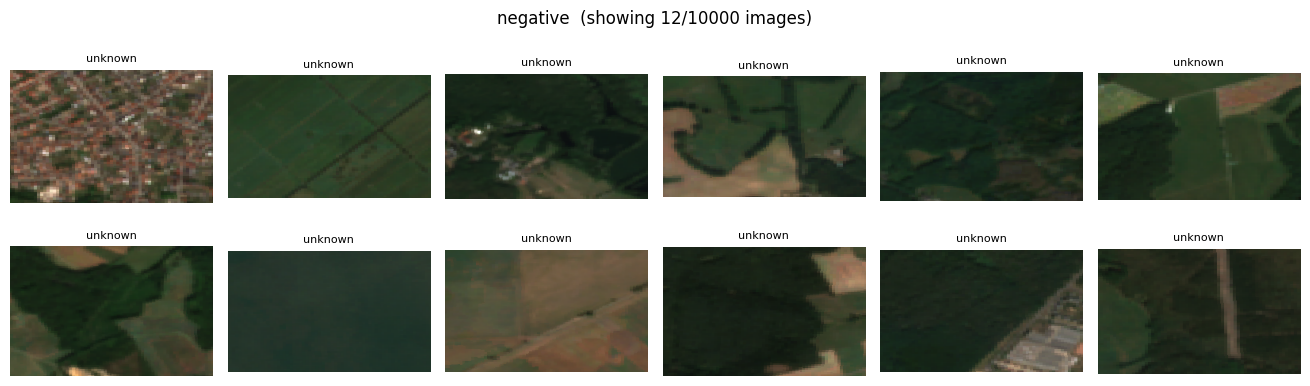

🖼 Saved collage: /content/previews/preview_negative.png
Class utility: 10000 PNG files found


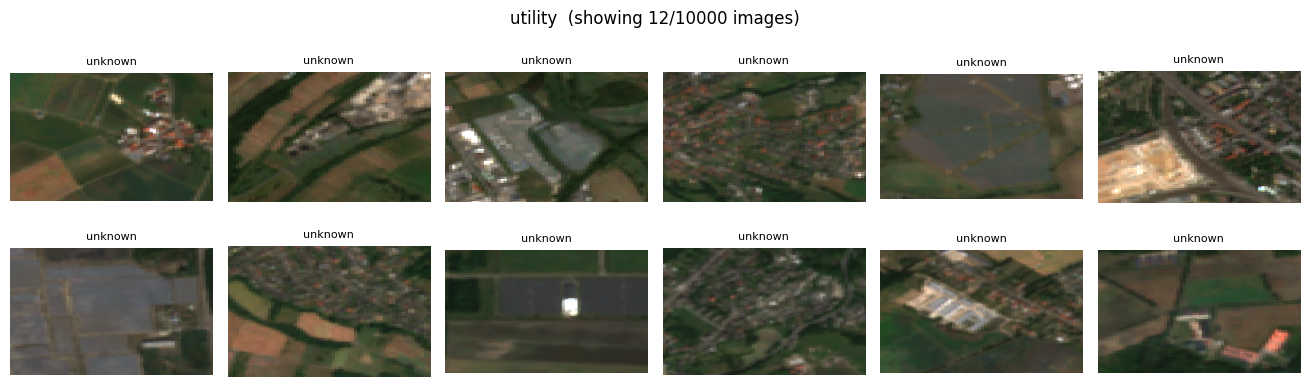

🖼 Saved collage: /content/previews/preview_utility.png

✅ Preview completed. Collages saved to: /content/previews


In [ ]:
# ========= Visualize sample images for each class =========
import os, random, math
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Root directory containing PNG images organized as:
#   EITHER: OUT_DIR_PNG / <label> / <subtype> / <lat>_<lon>_<subtype>.png
#   OR    : OUT_DIR_PNG / <label> / <lat>_<lon>_<subtype>.png
OUT_DIR_PNG = "/content/gee_patches_png"

# ✅ Only these two classes
CLASSES = ["negative", "utility"]

SAMPLES_PER_CLASS = 12     # Number of images to show per class
GRID_COLS = 6              # Number of columns in the preview grid
SAVE_PREVIEWS_DIR = "/content/previews"  # Directory to save collage previews

# Create the output directory if it does not exist
Path(SAVE_PREVIEWS_DIR).mkdir(parents=True, exist_ok=True)

def list_pngs(class_dir):
    """Recursively list all PNG files under a given class directory."""
    pngs = []
    if not os.path.isdir(class_dir):
        return pngs
    for root, _, files in os.walk(class_dir):
        for f in files:
            if f.lower().endswith(".png"):
                pngs.append(os.path.join(root, f))
    return pngs

def infer_subtype(label, path_str):
    """
    Infer subtype for display:
      - If parent folder is not the label, treat parent as subtype (nested layout).
      - Otherwise parse the filename suffix: <lat>_<lon>_<subtype>.png
    """
    p = Path(path_str)
    parent_name = p.parent.name
    if parent_name.lower() != label.lower():
        return parent_name  # nested subtype folder
    # fallback: parse from filename
    stem = p.stem  # e.g., "48.12345_9.12345_farm"
    parts = stem.split("_")
    return parts[-1] if len(parts) >= 3 else "unknown"

def visualize_class(label, paths, k=12, grid_cols=6, save_dir=None):
    """Display a random selection of images from a given class in a grid."""
    if len(paths) == 0:
        print(f"[WARN] No PNG files found for class '{label}'.")
        return

    sel = random.sample(paths, k=min(k, len(paths)))
    grid_rows = math.ceil(len(sel) / grid_cols)

    fig_w = grid_cols * 2.2
    fig_h = grid_rows * 2.2
    fig = plt.figure(figsize=(fig_w, fig_h))
    fig.suptitle(f"{label}  (showing {len(sel)}/{len(paths)} images)", y=0.95)

    for i, p in enumerate(sel, 1):
        ax = plt.subplot(grid_rows, grid_cols, i)
        try:
            img = Image.open(p)
            ax.imshow(img)
        except Exception:
            ax.text(0.5, 0.5, "Load error", ha="center", va="center")
        subtype = infer_subtype(label, p)
        ax.set_title(subtype, fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    if save_dir:
        out_path = os.path.join(save_dir, f"preview_{label}.png")
        fig.savefig(out_path, dpi=150, bbox_inches="tight")
        print(f"🖼 Saved collage: {out_path}")

# Main process: iterate over each class
for cls in CLASSES:
    cls_dir = os.path.join(OUT_DIR_PNG, cls)
    all_pngs = list_pngs(cls_dir)
    print(f"Class {cls}: {len(all_pngs)} PNG files found")
    visualize_class(cls, all_pngs, k=SAMPLES_PER_CLASS, grid_cols=GRID_COLS, save_dir=SAVE_PREVIEWS_DIR)

print(f"\n✅ Preview completed. Collages saved to: {SAVE_PREVIEWS_DIR}")


In [ ]:
# Save data in colab environment
from google.colab import files
import os

ROOT = "/content/gee_patches_png"
labels = ["negative", "utility"]

for cls in labels:
    src = os.path.join(ROOT, cls)
    if not os.path.isdir(src):
        print(f"Skip: {src} doesn't exist")
        continue
    zip_path = f"/content/{cls}.zip"
    !zip -r -q "$zip_path" "$src"
    print("Pack succeed:", zip_path)
    files.download(zip_path)


Pack succeed: /content/negative.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Pack succeed: /content/utility.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

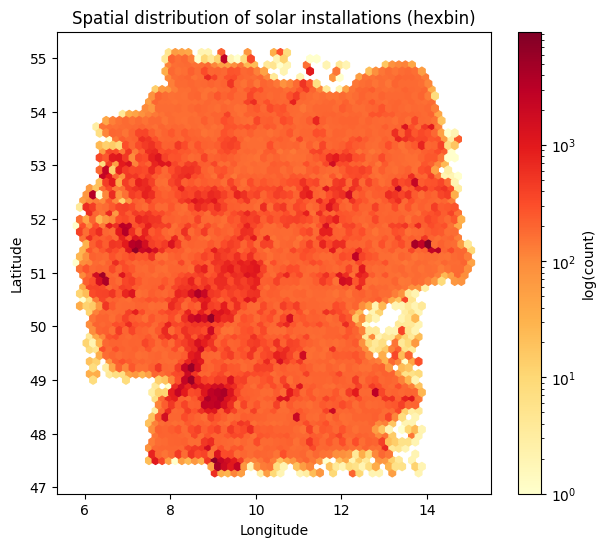

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.hexbin(df_cleaned["lon"], df_cleaned["lat"], gridsize=60, bins="log", cmap="YlOrRd")
plt.colorbar(label="log(count)")
plt.title("Spatial distribution of solar installations (hexbin)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()


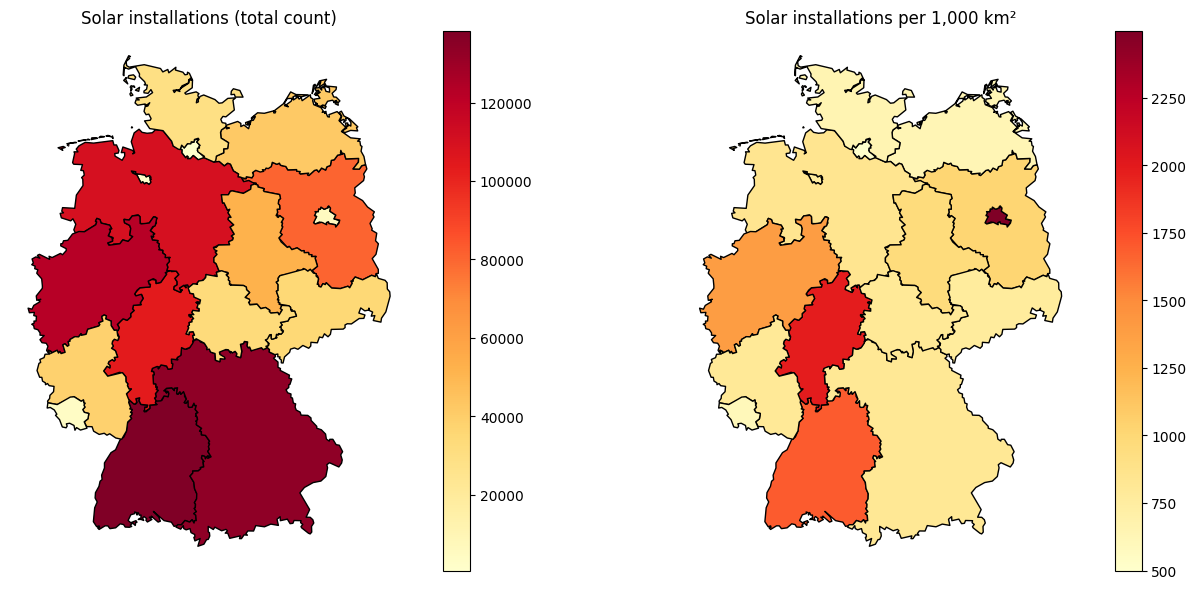

In [17]:
# ================================================
# Side-by-side maps: total counts vs. density (per 1,000 km²)
# ================================================

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Make a fresh working copy
states_m = states.copy()

# Ensure we have a single 'solar_count' column
if "solar_count" not in states_m.columns:
    sc_cols = [c for c in states_m.columns if c.startswith("solar_count")]
    if len(sc_cols) >= 1:
        states_m["solar_count"] = states_m[sc_cols].max(axis=1)
        states_m = states_m.drop(columns=[c for c in sc_cols if c != "solar_count"])
    else:
        # If completely missing, merge in counts computed from the spatial join
        states_m = states_m.merge(counts, on="state", how="left")

# Replace NaNs with 0 (states with no installations)
states_m["solar_count"] = states_m["solar_count"].fillna(0)

# Compute area in km² using a metric CRS
states_m_3857 = states_m.to_crs(3857)
states_m["area_km2"] = states_m_3857.geometry.area / 1e6

# Density per 1,000 km² (avoid division by zero with a tiny epsilon)
states_m["solar_per_1000km2"] = states_m["solar_count"] / (states_m["area_km2"] / 1000.0 + 1e-9)

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: total counts
states_m.plot(
    column="solar_count",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Solar installations (total count)")
axes[0].axis("off")

# Right: density per 1,000 km²
states_m.plot(
    column="solar_per_1000km2",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("Solar installations per 1,000 km²")
axes[1].axis("off")

plt.tight_layout()
plt.show()


#2. Build CNN model

In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import random
import shutil
import zipfile
import re
from pathlib import Path
random.seed(42)
ROOT = Path("/mnt/data/dataset")
RAW = ROOT/"raw"
SPLIT = ROOT/"splits"

def ensure_clear(path: Path):
    if path.exists(): shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def extract_images(zip_path, class_name):
    dst = RAW/class_name
    ensure_clear(dst)
    exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
    with zipfile.ZipFile(zip_path,'r') as zf:
        for m in zf.namelist():
            if m.endswith("/"): continue
            ext = Path(m).suffix.lower()
            if ext in exts:
                base = Path(m).name
                base = re.sub(r"[^A-Za-z0-9_.-]","_",base)
                out_path = dst/base
                i=1
                while out_path.exists():
                    out_path = dst/f"{out_path.stem}_{i}{out_path.suffix}"
                    i+=1
                with zf.open(m) as src, open(out_path,"wb") as dstf:
                    shutil.copyfileobj(src,dstf)
    return dst


pos_zip = "utility.zip"
neg_zip = "negative.zip"

# Unzip
ensure_clear(RAW)
pos_dir = extract_images(pos_zip,"utility")
neg_dir = extract_images(neg_zip,"negative")

# Split
for split in ["train","val","test"]:
    for cls in ["utility","negative"]:
        (SPLIT/split/cls).mkdir(parents=True, exist_ok=True)

def split_copy(cls_dir, cls_name):
    files = list(cls_dir.glob("*"))
    random.shuffle(files)
    n = len(files)
    n_train, n_val = int(0.6*n), int(0.2*n)
    train, val, test = files[:n_train], files[n_train:n_train+n_val], files[n_train+n_val:]
    for subset, subset_files in [("train",train),("val",val),("test",test)]:
        for f in subset_files:
            shutil.copy2(f, SPLIT/subset/cls_name/f.name)
    print(cls_name, n, len(train), len(val), len(test))

split_copy(pos_dir,"utility")
split_copy(neg_dir,"negative")

utility 10000 6000 2000 2000
negative 10000 6000 2000 2000


In [6]:
IMG_SIZE = 128
BATCH = 32

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(SPLIT / "train", transform=train_tfms)
val_ds   = datasets.ImageFolder(SPLIT / "val",   transform=test_tfms)
test_ds  = datasets.ImageFolder(SPLIT / "test",  transform=test_tfms)

# DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH)
test_loader  = DataLoader(test_ds, batch_size=BATCH)

print("Classes:", train_ds.classes)


Classes: ['negative', 'utility']


Epoch 1/30 | Train loss 0.4699 | Val loss 0.3279
Epoch 2/30 | Train loss 0.3609 | Val loss 0.3255
Epoch 3/30 | Train loss 0.3430 | Val loss 0.5700
Epoch 4/30 | Train loss 0.3364 | Val loss 0.3000
Epoch 5/30 | Train loss 0.3196 | Val loss 0.2893
Epoch 6/30 | Train loss 0.3184 | Val loss 0.3065
Epoch 7/30 | Train loss 0.3065 | Val loss 0.2979
Epoch 8/30 | Train loss 0.3003 | Val loss 0.3602
Epoch 9/30 | Train loss 0.2978 | Val loss 0.2715
Epoch 10/30 | Train loss 0.2922 | Val loss 0.2642
Epoch 11/30 | Train loss 0.2898 | Val loss 0.2777
Epoch 12/30 | Train loss 0.2840 | Val loss 0.3053
Epoch 13/30 | Train loss 0.2859 | Val loss 0.2558
Epoch 14/30 | Train loss 0.2762 | Val loss 0.2674
Epoch 15/30 | Train loss 0.2760 | Val loss 0.2578
Epoch 16/30 | Train loss 0.2742 | Val loss 0.2661
Epoch 17/30 | Train loss 0.2681 | Val loss 0.2375
Epoch 18/30 | Train loss 0.2706 | Val loss 0.2471
Epoch 19/30 | Train loss 0.2710 | Val loss 0.2432
Epoch 20/30 | Train loss 0.2671 | Val loss 0.2531
Epoch 21/

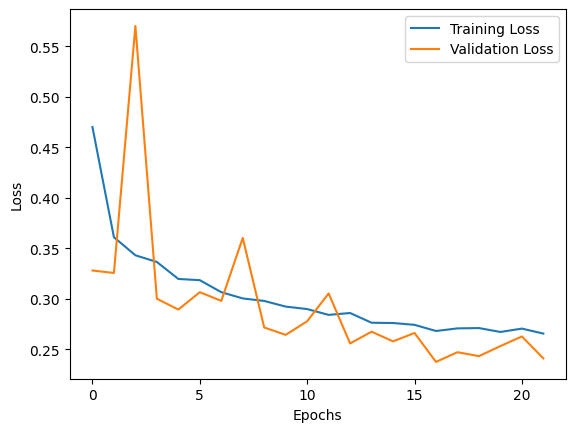

Classification Report:
              precision    recall  f1-score   support

    negative     0.9450    0.8737    0.9079      2810
     utility     0.8819    0.9488    0.9141      2793

    accuracy                         0.9111      5603
   macro avg     0.9134    0.9112    0.9110      5603
weighted avg     0.9135    0.9111    0.9110      5603

Confusion Matrix:
[[2455  355]
 [ 143 2650]]


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ==================== Parameters ====================
IMG_SIZE = 64
BATCH = 32
EPOCHS = 30
PATIENCE = 5
LR = 0.001
REG = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# ==================== Define CNN model ====================
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        last_conv_output = x
        x = self.classifier(x)
        return x, last_conv_output

cnn_model = CNN(num_classes=2).to(DEVICE)

# ==================== EarlyStopping ====================
class EarlyStopping:
    def __init__(self, patience=5, path="best_cnn.pt"):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ==================== Train the model ====================
def train_cnn_model(epochs, model, optimizer, criterion,
                    train_loader, val_loader, early_stopper, device=DEVICE):
    train_losses, val_losses = [], []
    model.to(device)

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss, n = 0.0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            n += x.size(0)
        train_loss = running_loss / n
        train_losses.append(train_loss)

        # ---- Validation ----
        model.eval()
        vloss, m = 0.0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits, _ = model(x)
                loss = criterion(logits, y)
                vloss += loss.item() * x.size(0)
                m += x.size(0)
        val_loss = vloss / m
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train loss {train_loss:.4f} | Val loss {val_loss:.4f}")

        # ---- Early Stopping ----
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

# ==================== Initial training ====================
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=LR, weight_decay=REG)
early_stopper = EarlyStopping(patience=PATIENCE, path="best_cnn.pt")

train_losses, val_losses = train_cnn_model(
    EPOCHS, cnn_model, cnn_optimizer, criterion,
    train_loader, val_loader, early_stopper, device=DEVICE
)

# ==================== Plot loss curve ====================
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ==================== Test Dataset Evaluation ====================
cnn_model.load_state_dict(torch.load("best_cnn.pt", map_location=DEVICE))
cnn_model.eval()
all_y, all_p = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits, _ = cnn_model(x)
        pred = logits.argmax(1).cpu().numpy()
        all_p.extend(pred)
        all_y.extend(y.cpu().numpy())

print("Classification Report:")
print(classification_report(all_y, all_p, target_names=test_ds.classes, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(all_y, all_p))


3. Test Data

In [ ]:
# US Sentinel-2 Utility & Negative Patch Downloader (Total: 3000)
# Regions: California (1000 = 500 utility + 500 negative),
#          Texas (1000), Arizona (1000)
# Saves per-region zips as <region>_utility.zip and <region>_negative.zip

import os
import random
import requests
from tqdm import tqdm
import numpy as np
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
import zipfile
from pathlib import Path

# -------------------- CONFIG --------------------
# Earth Engine
import ee
EE_PROJECT = 'spring-archive-464114-v4'  # <- kendi projenle değiştir

DATE_START = "2022-04-01"
DATE_END   = "2022-10-31"
PIXELS = 256
PATCH_SIDE_M = 640
S2_COLL = "COPERNICUS/S2_SR_HARMONIZED"
VIS = {"min": 0, "max": 3000}

# Toplam 3,000 hedefi: 1000 CA + 1000 TX + 1000 AZ
REGIONS = [
    {"label": "california", "query": "California, USA", "n_utility": 500, "n_negative": 500},
    {"label": "texas",      "query": "Texas, USA",      "n_utility": 500, "n_negative": 500},
    {"label": "arizona",    "query": "Arizona, USA",    "n_utility": 500, "n_negative": 500},
]
ROOT_DIR = "usa_patches"
random.seed(42)
np.random.seed(42)

# -------------------- HELPERS --------------------
def init_ee():
    try:
        ee.Initialize(project=EE_PROJECT)
    except Exception:
        ee.Authenticate()
        ee.Initialize(project=EE_PROJECT)

def s2_sr_cloudmask(img):
    # S2 SR cloud probability & SCL mask (avoid clouds, cloud-shadows, cirrus)
    mask = img.select("MSK_CLDPRB").lt(40)
    scl  = img.select("SCL")
    scl_mask = (scl.neq(3)).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))
    return img.updateMask(mask.And(scl_mask))

def make_region(lon, lat, side_m=PATCH_SIDE_M):
    half = side_m / 2.0
    pt = ee.Geometry.Point([lon, lat])
    return pt.transform("EPSG:3857", 1).buffer(half).bounds().transform("EPSG:4326", 1)

def get_thumb_url(image, region, dimensions, vis):
    vis_img = image.visualize(**vis)
    params = {"region": region, "dimensions": dimensions, "format": "png"}
    return vis_img.getThumbURL(params)

def download_png_by_url(url, out_path, timeout=180):
    r = requests.get(url, stream=True, timeout=timeout)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

def extract_centers(elements):
    out = []
    for e in elements:
        if "lat" in e and "lon" in e:
            lat, lon = e["lat"], e["lon"]
        elif "center" in e:
            lat, lon = e["center"]["lat"], e["center"]["lon"]
        else:
            continue
        out.append((float(lat), float(lon)))
    return out

def query_overpass_solar(miny, minx, maxy, maxx, timeout=1800):
    query = f"""
    [out:json][timeout:{timeout}];
    (
      node["power"="plant"]["plant:source"="solar"]({miny},{minx},{maxy},{maxx});
      way ["power"="plant"]["plant:source"="solar"]({miny},{minx},{maxy},{maxx});
      rel ["power"="plant"]["plant:source"="solar"]({miny},{minx},{maxy},{maxx});
      node["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
      way ["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
      rel ["generator:source"="solar"]({miny},{minx},{maxy},{maxx});
    );
    out center tags;
    """
    r = requests.post("https://overpass-api.de/api/interpreter", data={"data": query}, timeout=timeout)
    r.raise_for_status()
    return r.json().get("elements", [])

def sample_negatives(ca_poly, utility_coords, n_negative, max_attempts=150000):
    neg_coords = []
    attempts = 0
    # very rough ~300m exclusion via degree distances
    while len(neg_coords) < n_negative and attempts < max_attempts:
        lat = np.random.uniform(ca_poly.bounds[1], ca_poly.bounds[3])
        lon = np.random.uniform(ca_poly.bounds[0], ca_poly.bounds[2])
        pt = Point(lon, lat)
        if not ca_poly.contains(pt):
            attempts += 1
            continue
        too_close = False
        for ulat, ulon in utility_coords:
            if abs(ulat-lat) < 0.003 and abs(ulon-lon) < 0.003:
                if Point(ulon, ulat).distance(pt) < 0.003:
                    too_close = True
                    break
        if too_close:
            attempts += 1
            continue
        neg_coords.append((lat, lon))
        attempts += 1
    return neg_coords

def zip_folder(src_dir, zip_path):
    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(src_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, src_dir)
                zf.write(file_path, arcname)

# -------------------- PIPELINE --------------------
def main():
    os.makedirs(ROOT_DIR, exist_ok=True)

    print("== Initializing Earth Engine ==")
    init_ee()

    print("== Preparing Sentinel-2 collection ==")
    s2 = ee.ImageCollection(S2_COLL).filterDate(DATE_START, DATE_END).map(s2_sr_cloudmask)
    median_rgb = s2.median().select(["B4", "B3", "B2"])

    for region in REGIONS:
        label = region["label"].lower().replace(" ", "_")
        query = region["query"]
        N_UTILITY = int(region["n_utility"])
        N_NEGATIVE = int(region["n_negative"])

        region_dir = os.path.join(ROOT_DIR, label)
        util_dir   = os.path.join(region_dir, "utility")
        neg_dir    = os.path.join(region_dir, "negative")
        os.makedirs(util_dir, exist_ok=True)
        os.makedirs(neg_dir, exist_ok=True)

        print(f"\n================ {label.upper()} ================")
        print(f"== Getting AOI for: {query} ==")
        aoi = ox.geocode_to_gdf(query).to_crs("EPSG:4326")
        poly = aoi.geometry.iloc[0]
        minx, miny, maxx, maxy = poly.bounds

        print("== Querying Overpass for utility-scale solar ==")
        elements = query_overpass_solar(miny, minx, maxy, maxx)
        utility_coords_all = extract_centers(elements)
        print(f"Found {len(utility_coords_all)} solar features in AOI.")

        if len(utility_coords_all) < N_UTILITY:
            raise RuntimeError(f"[{label}] Not enough utility samples found ({len(utility_coords_all)}) for requested {N_UTILITY}. Try a larger AOI or different region.")

        random.shuffle(utility_coords_all)
        utility_coords = utility_coords_all[:N_UTILITY]

        print("== Sampling negative locations ==")
        neg_coords = sample_negatives(poly, utility_coords, N_NEGATIVE)
        if len(neg_coords) < N_NEGATIVE:
            print(f"[WARN][{label}] Only {len(neg_coords)} negative samples were generated (requested {N_NEGATIVE}).")

        print(f"== Downloading {len(utility_coords)} utility patches ==")
        for (lat, lon) in tqdm(utility_coords, desc=f"{label} utility"):
            out_path = os.path.join(util_dir, f"{lat:.5f}_{lon:.5f}_utility.png")
            if os.path.exists(out_path):
                continue
            region_geom = make_region(lon, lat)
            try:
                url = get_thumb_url(median_rgb, region_geom, PIXELS, VIS)
                download_png_by_url(url, out_path)
            except Exception as e:
                print(f"[FAIL] {out_path} -> {repr(e)}")

        print(f"== Downloading {len(neg_coords)} negative patches ==")
        for (lat, lon) in tqdm(neg_coords, desc=f"{label} negative"):
            out_path = os.path.join(neg_dir, f"{lat:.5f}_{lon:.5f}_negative.png")
            if os.path.exists(out_path):
                continue
            region_geom = make_region(lon, lat)
            try:
                url = get_thumb_url(median_rgb, region_geom, PIXELS, VIS)
                download_png_by_url(url, out_path)
            except Exception as e:
                print(f"[FAIL] {out_path} -> {repr(e)}")

        # Zip per region with required names
        util_zip = f"{label}_utility.zip"
        neg_zip  = f"{label}_negative.zip"
        print(f"== Zipping {label} ==")
        zip_folder(util_dir, util_zip)
        zip_folder(neg_dir,  neg_zip)
        print(f"✅ Saved {util_zip} and {neg_zip}")

    print("\nAll done. Regions zipped individually as <region>_utility.zip and <region>_negative.zip")

if __name__ == "__main__":
    main()


Utility: 1499, Negative: 1498, Total: 2997


Model inference: 100%|██████████| 2997/2997 [01:01<00:00, 49.02it/s]


Evaluated 2997 images.

Classification Report (US utility/negative):
              precision    recall  f1-score   support

    negative     0.5364    0.8605    0.6609      1498
     utility     0.6481    0.2568    0.3679      1499

    accuracy                         0.5586      2997
   macro avg     0.5923    0.5587    0.5144      2997
weighted avg     0.5923    0.5586    0.5143      2997

Confusion Matrix:
[[1289  209]
 [1114  385]]
Accuracy: 0.5586


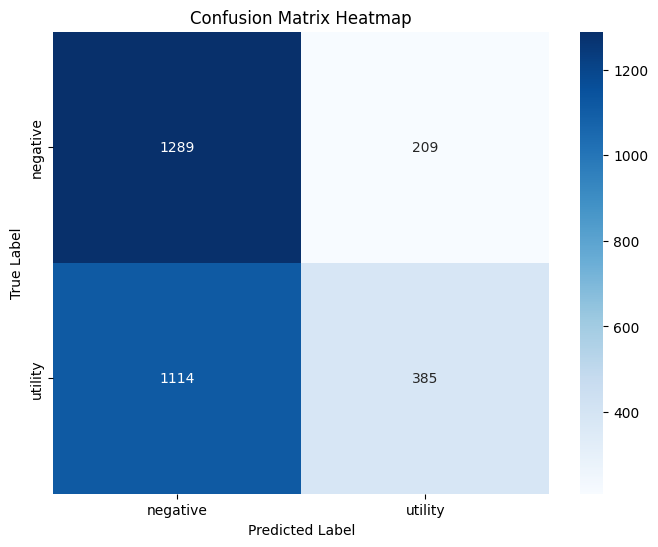

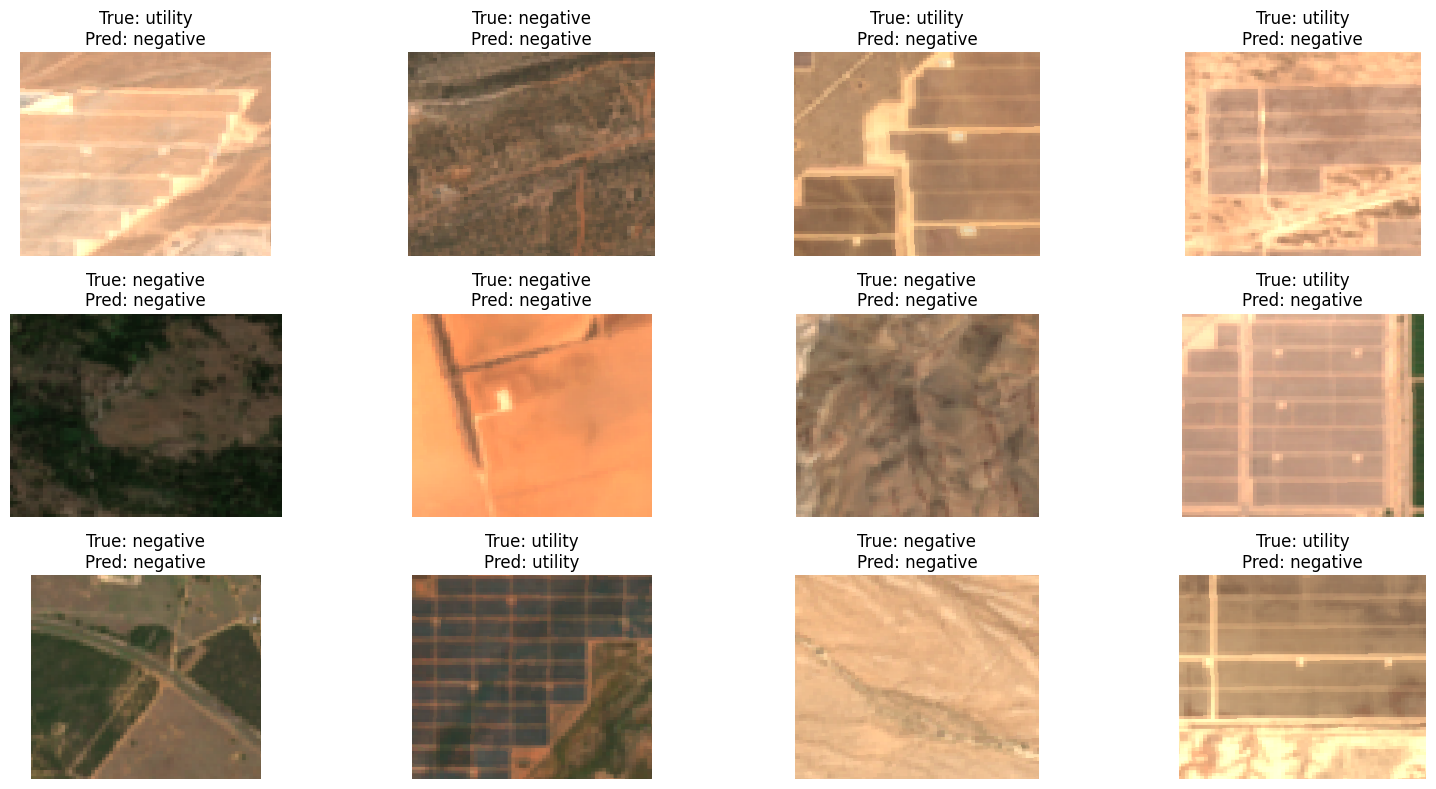

In [12]:
import os
import zipfile
import shutil
import random
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns  # YENİ: Seaborn kütüphanesini içe aktar

# --- 1. Unzip test sets ---
TMP_DIR = "usa_test_tmp"
UTILITY_DIR = os.path.join(TMP_DIR, "utility")
NEGATIVE_DIR = os.path.join(TMP_DIR, "negative")
os.makedirs(UTILITY_DIR, exist_ok=True)
os.makedirs(NEGATIVE_DIR, exist_ok=True)

def unzip_to_dir(zip_path, out_dir):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir)

unzip_to_dir("california_utility.zip", UTILITY_DIR)
unzip_to_dir("texas_utility.zip", UTILITY_DIR)
unzip_to_dir("arizona_utility.zip", UTILITY_DIR)
unzip_to_dir("california_negative.zip", NEGATIVE_DIR)
unzip_to_dir("texas_negative.zip", NEGATIVE_DIR)
unzip_to_dir("arizona_negative.zip", NEGATIVE_DIR)

# --- 2. List all images and labels ---
utility_imgs = [os.path.join(UTILITY_DIR, f) for f in os.listdir(UTILITY_DIR) if f.lower().endswith(".png")]
negative_imgs = [os.path.join(NEGATIVE_DIR, f) for f in os.listdir(NEGATIVE_DIR) if f.lower().endswith(".png")]

all_paths = utility_imgs + negative_imgs
all_labels = [1]*len(utility_imgs) + [0]*len(negative_imgs)  # 1: utility, 0: negative

print(f"Utility: {len(utility_imgs)}, Negative: {len(negative_imgs)}, Total: {len(all_paths)}")

# --- 3. Load trained model ---
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        last_conv_output = x
        x = self.classifier(x)
        return x, last_conv_output

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN(num_classes=2).to(DEVICE)
cnn_model.load_state_dict(torch.load("best_cnn.pt", map_location=DEVICE))
cnn_model.eval()

# --- 4. Define test transform (match your training pipeline) ---
IMG_SIZE = 64
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- 5. Inference ---
all_preds = []
with torch.no_grad():
    for path in tqdm(all_paths, desc="Model inference"):
        try:
            img = Image.open(path).convert("RGB")
            x = test_tfms(img).unsqueeze(0).to(DEVICE)
            logits, _ = cnn_model(x)
            pred = logits.argmax(1).item()
            all_preds.append(pred)
        except Exception as e:
            print(f"[ERROR] {path}: {e}")
            all_preds.append(None)

# --- 6. Filter out failed images ---
valid_idx = [i for i, p in enumerate(all_preds) if p is not None]
y_true = [all_labels[i] for i in valid_idx]
y_pred = [all_preds[i] for i in valid_idx]
print(f"Evaluated {len(y_true)} images.")

# --- 7. Metrics ---
class_names = ["negative", "utility"]
print("\nClassification Report (US utility/negative):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy: %.4f" % accuracy_score(y_true, y_pred))

# #############################################################
# --- 8. YENİ: Visualize Confusion Matrix as Heatmap ---
# #############################################################
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 9. Visualize random predictions ---
label_map = {0: "negative", 1: "utility"}
n_show = 12
sel = random.sample(valid_idx, min(n_show, len(valid_idx)))
plt.figure(figsize=(16, 8))
for i, idx in enumerate(sel, 1):
    path = all_paths[idx]
    pred = all_preds[idx]
    true = all_labels[idx]
    try:
        img = Image.open(path)
        plt.subplot(3, 4, i)
        plt.imshow(img)
        plt.title(f"True: {label_map[true]}\nPred: {label_map.get(pred, '?')}")
        plt.axis("off")
    except Exception:
        plt.axis("off")
plt.tight_layout()
plt.show()

# --- 10. Cleanup temp dir (optional) ---
shutil.rmtree(TMP_DIR)

Utility: 1499, Negative: 1500, Total: 2999


Model inference: 100%|██████████| 2999/2999 [01:13<00:00, 40.95it/s]


Evaluated 2999 images.

Classification Report (EU utility/negative):
              precision    recall  f1-score   support

    negative     0.6502    0.6220    0.6358      1500
     utility     0.6375    0.6651    0.6510      1499

    accuracy                         0.6435      2999
   macro avg     0.6438    0.6436    0.6434      2999
weighted avg     0.6438    0.6435    0.6434      2999

Confusion Matrix:
[[933 567]
 [502 997]]
Accuracy: 0.6435


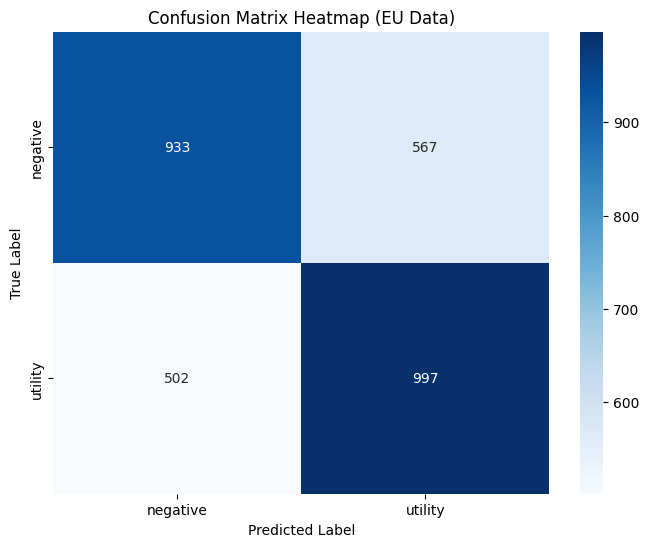

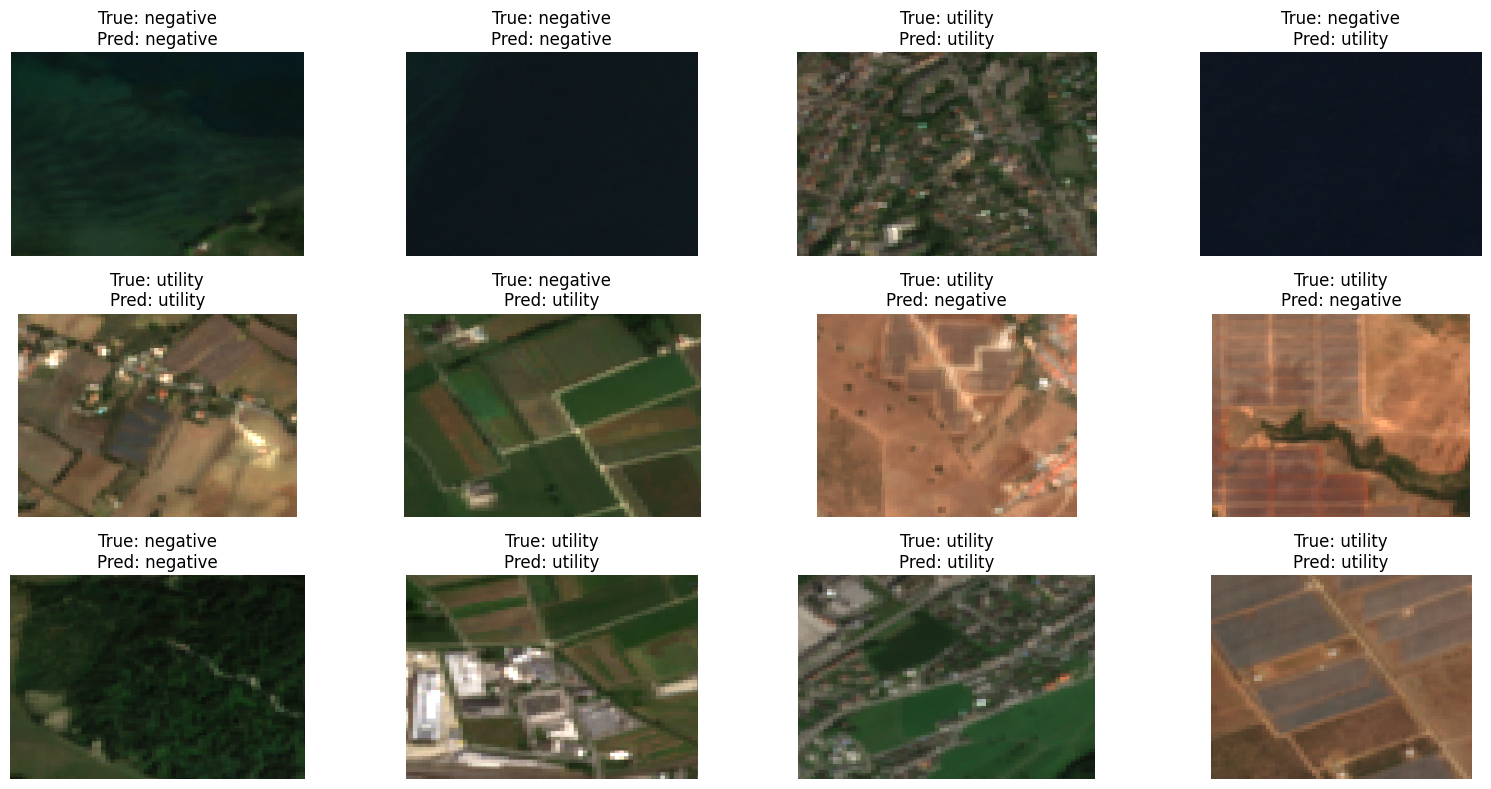

In [13]:
import os
import zipfile
import shutil
import random
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns # YENİ: Seaborn kütüphanesini içe aktar

# --- 1. Unzip test sets ---
TMP_DIR = "euro_test_tmp"
UTILITY_DIR = os.path.join(TMP_DIR, "utility")
NEGATIVE_DIR = os.path.join(TMP_DIR, "negative")
os.makedirs(UTILITY_DIR, exist_ok=True)
os.makedirs(NEGATIVE_DIR, exist_ok=True)

def unzip_to_dir(zip_path, out_dir):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir)

unzip_to_dir("italy_utility.zip", UTILITY_DIR)
unzip_to_dir("switzerland_utility.zip", UTILITY_DIR)
unzip_to_dir("spain_utility.zip", UTILITY_DIR)
unzip_to_dir("italy_negative.zip", NEGATIVE_DIR)
unzip_to_dir("switzerland_negative.zip", NEGATIVE_DIR)
unzip_to_dir("spain_negative.zip", NEGATIVE_DIR)

# --- 2. List all images and labels ---
utility_imgs = [os.path.join(UTILITY_DIR, f) for f in os.listdir(UTILITY_DIR) if f.lower().endswith(".png")]
negative_imgs = [os.path.join(NEGATIVE_DIR, f) for f in os.listdir(NEGATIVE_DIR) if f.lower().endswith(".png")]

all_paths = utility_imgs + negative_imgs
all_labels = [1]*len(utility_imgs) + [0]*len(negative_imgs)  # 1: utility, 0: negative

print(f"Utility: {len(utility_imgs)}, Negative: {len(negative_imgs)}, Total: {len(all_paths)}")

# --- 3. Load trained model ---
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        last_conv_output = x
        x = self.classifier(x)
        return x, last_conv_output

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN(num_classes=2).to(DEVICE)
cnn_model.load_state_dict(torch.load("best_cnn.pt", map_location=DEVICE))
cnn_model.eval()

# --- 4. Define test transform (match your training pipeline) ---
IMG_SIZE = 64
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- 5. Inference ---
all_preds = []
with torch.no_grad():
    for path in tqdm(all_paths, desc="Model inference"):
        try:
            img = Image.open(path).convert("RGB")
            x = test_tfms(img).unsqueeze(0).to(DEVICE)
            logits, _ = cnn_model(x)
            pred = logits.argmax(1).item()
            all_preds.append(pred)
        except Exception as e:
            print(f"[ERROR] {path}: {e}")
            all_preds.append(None)

# --- 6. Filter out failed images ---
valid_idx = [i for i, p in enumerate(all_preds) if p is not None]
y_true = [all_labels[i] for i in valid_idx]
y_pred = [all_preds[i] for i in valid_idx]
print(f"Evaluated {len(y_true)} images.")

# --- 7. Metrics ---
class_names = ["negative", "utility"]
print("\nClassification Report (EU utility/negative):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy: %.4f" % accuracy_score(y_true, y_pred))


# #############################################################
# --- 8. YENİ: Visualize Confusion Matrix as Heatmap ---
# #############################################################
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap (EU Data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 9. Visualize random predictions ---
label_map = {0: "negative", 1: "utility"}
n_show = 12
sel = random.sample(valid_idx, min(n_show, len(valid_idx)))
plt.figure(figsize=(16, 8))
for i, idx in enumerate(sel, 1):
    path = all_paths[idx]
    pred = all_preds[idx]
    true = all_labels[idx]
    try:
        img = Image.open(path)
        plt.subplot(3, 4, i)
        plt.imshow(img)
        plt.title(f"True: {label_map[true]}\nPred: {label_map.get(pred, '?')}")
        plt.axis("off")
    except Exception:
        plt.axis("off")
plt.tight_layout()
plt.show()

# --- 10. Cleanup temp dir (optional) ---
shutil.rmtree(TMP_DIR)